In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate
from tensorflow.keras.layers import Embedding, dot, Dot
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence


import time
import numpy as np
import sys
import io
import os
import codecs
import random
import json
import re
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import collections
import os
import zipfile

import numpy as np

import pickle 
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
quran_encoder = load_obj('quran_encoder')
sutras_encoder = load_obj('sutras_encoder')
vedas_encoder = load_obj('vedas_encoder')
bible_encoder = load_obj('bible_encoder')
tanakh_encoder = load_obj('tanakh_encoder')



In [4]:
quran_decoder = load_obj('quran_decoder')
sutras_decoder = load_obj('sutras_decoder')
vedas_decoder = load_obj('vedas_decoder')
bible_decoder = load_obj('bible_decoder')
tanakh_decoder = load_obj('tanakh_decoder')


In [5]:
def get_weights_from_file(fp):
    f = h5py.File(fp, 'r')
    # will get a list of layer names which you can use as index
    d = f['embedding']
    d = d[list(d.keys())[0]]
    d = d[list(d.keys())[0]]
    return d

#The data format is h5 so you can directly use the h5py library to inspect and load the weights. From the quickstart guide:
sutras_emb = get_weights_from_file('./weights/sutras.h5')
vedas_emb = get_weights_from_file('./weights/vedas.h5')
bible_emb = get_weights_from_file('./weights/bible.h5')
tanakh_emb = get_weights_from_file('./weights/tanakh.h5')
quran_emb = get_weights_from_file('./weights/quran.h5')

In [6]:
sutras_emb = pd.DataFrame(sutras_emb)
vedas_emb = pd.DataFrame(vedas_emb)
bible_emb = pd.DataFrame(bible_emb)
tanakh_emb = pd.DataFrame(tanakh_emb)
quran_emb = pd.DataFrame(quran_emb)

# Words that exist in all files and visualization

In [170]:
universe = set.intersection(set(sutras_encoder.keys()),
                     set(vedas_encoder.keys()),
                     set(bible_encoder.keys()),
                     set(tanakh_encoder.keys()),
                     set(quran_encoder.keys()))
universe = list(universe)

In [187]:
skf = load_obj('sutras_kept_freq')
vkf = load_obj('vedas_kept_freq')
bkf = load_obj('bible_kept_freq')
tkf = load_obj('tanakh_kept_freq')
qkf = load_obj('quran_kept_freq')

In [191]:
sutras_unverse_count = [skf[term] for term in universe]
vedas_unverse_count = [vkf[term] for term in universe]
bible_unverse_count = [bkf[term] for term in universe]
tanakh_unverse_count = [tkf[term] for term in universe]
quran_unverse_count = [qkf[term] for term in universe]


In [280]:
freq_df = pd.concat([pd.DataFrame(sutras_unverse_count),
                     pd.DataFrame(vedas_unverse_count),
                     pd.DataFrame(bible_unverse_count),
                     pd.DataFrame(tanakh_unverse_count),
                     pd.DataFrame(quran_unverse_count)], axis = 1)
freq_df.index = universe
freq_df.columns = ['sutras','vedas','bible','tanakh','quran']
freq_df['most_common'] = freq_df.sum(axis = 1)
freq_df = freq_df.sort_values(by = 'most_common')
freq_df

,sutras,vedas,bible,tanakh,quran,most_common
married,5,6,30,10,5,56
restored,13,13,27,5,6,64
theirs,12,15,21,10,11,69
skins,13,6,24,24,8,75
staff,7,6,44,8,11,76
...,...,...,...,...,...,...
in,24146,9356,12725,2314,1921,50462
to,30777,13697,13660,2220,3249,63603
of,49595,17584,34791,7282,3501,112753
and,46662,13535,51765,11671,6853,130486


In [281]:

freq_df.drop('most_common', inplace = True, axis = 1)
freq_df

,sutras,vedas,bible,tanakh,quran
married,5,6,30,10,5
restored,13,13,27,5,6
theirs,12,15,21,10,11
skins,13,6,24,24,8
staff,7,6,44,8,11
...,...,...,...,...,...
in,24146,9356,12725,2314,1921
to,30777,13697,13660,2220,3249
of,49595,17584,34791,7282,3501
and,46662,13535,51765,11671,6853


(array([147., 148., 119.,  79.,  65.,  27.,  21.,  15.,  14.,   4.]),
 array([1.60943791, 2.33509586, 3.06075381, 3.78641176, 4.51206971,
        5.23772766, 5.9633856 , 6.68904355, 7.4147015 , 8.14035945,
        8.8660174 ]),
 <a list of 10 Patch objects>)

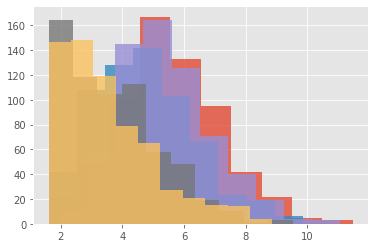

In [279]:
plt.hist(np.log(freq_df['sutras']), alpha = .8)
plt.hist(np.log(freq_df['vedas']), alpha = .8)
plt.hist(np.log(freq_df['bible']), alpha = .8)
plt.hist(np.log(freq_df['tanakh']), alpha = .8)
plt.hist(np.log(freq_df['quran']), alpha = .8)

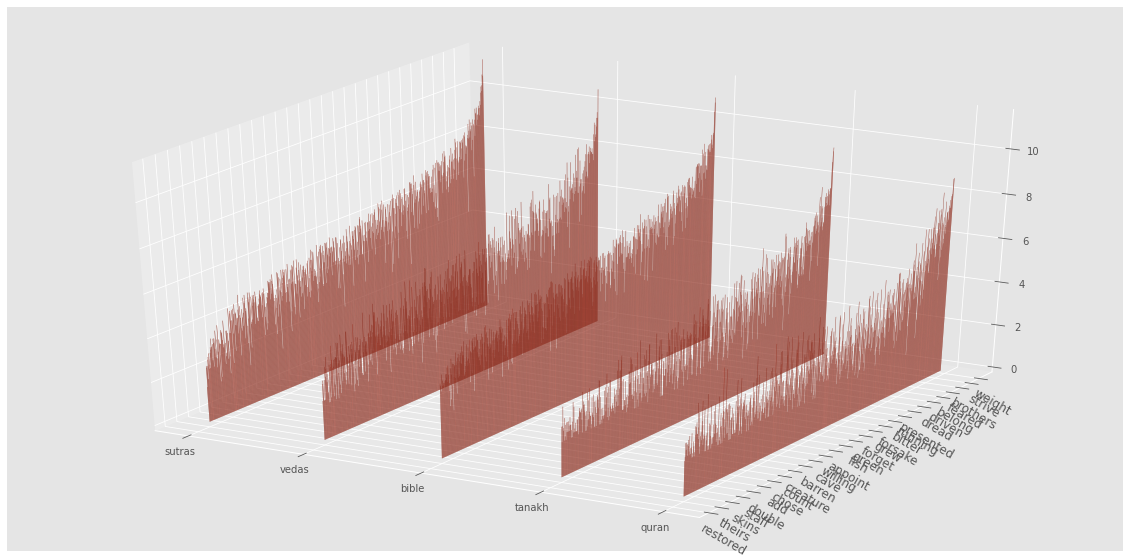

In [274]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
data_2d = freq_df.values

data_array = np.array(np.log(data_2d))

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')
x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()
ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          0, 1, z_data , alpha = .5)



ax.w_xaxis.set_ticklabels(freq_df.columns)
ax.w_yaxis.set_ticklabels(freq_df.index)

ticksx = np.arange(0.0, 5, 1)
plt.xticks(ticksx, freq_df.columns)

ticksy = np.arange(0.0, len(freq_df.index), 1)
plt.yticks(ticksy, freq_df.index)
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=25.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
plt.yticks(fontsize=12)
plt.yticks(rotation=-30)
plt.show()

In [171]:
print(universe)

['until', 'mount', 'destroyed', 'strong', 'among', 'lot', 'river', 'worship', 'between', 'him', 'fine', 'other', 'beneath', 'either', 'enemies', 'he', 'approach', 'neither', 'touched', 'food', 'together', 'refuge', 'east', 'therein', 'married', 'little', 'down', 'never', 'most', 'knowledge', 'power', 'true', 'change', 'ourselves', 'commit', 'been', 'they', 'was', 'sound', 'divided', 'flesh', 'prepared', 'their', 'many', 'double', 'dwelling', 'back', 'hold', 'lords', 'ones', 'being', 'wickedness', 'sins', 'measure', 'places', 'committed', 'creature', 'prosper', 'rain', 'head', 'received', 'appeared', 'now', 'command', 'king', 'indeed', 'beyond', 'those', 'kindness', 'left', 'high', 'rivers', 'place', 'sleep', 'female', 'doing', 'held', 'any', 'against', 'let', 'small', 'bird', 'yet', 'may', 'how', 'ever', 'wait', 'opened', 'child', 'pieces', 'faces', 'evil', 'drink', 'brought', 'after', 'looked', 'also', 'gather', 'increase', 'full', 'behind', 'where', 'passed', 'draw', 'or', 'who', 'ol

In [173]:
'pleasure' in universe

False

## Pairwise Similarity

In [174]:
from sklearn.metrics.pairwise import euclidean_distances


search_terms = ['god', 'gods', 'strength',
                'light','darkness', 'man', 'woman', 
                'good', 'evil', 'earth', 'men', 'life', 'death']
names = ['sutras', 'vedas', 'bible', 'tanakh', 'quran']
embeddings = [sutras_emb, vedas_emb, bible_emb, tanakh_emb, quran_emb]
decoders = [sutras_decoder, vedas_decoder, bible_decoder,tanakh_decoder, quran_decoder]
encoders= [sutras_encoder, vedas_encoder, bible_encoder,tanakh_encoder, quran_encoder]

In [175]:
def dm(embeddings: list): 
    distance_matrix = euclidean_distances(embeddings)
    print(distance_matrix.shape)
    return distance_matrix



def similar_words(distance_matrix, search_terms: list, encoder, decoder, n: int):
    sw = {search_term: [decoder[idx] for idx in distance_matrix[encoder[search_term]-1]
                                   .argsort()[1:n]+1] 
                   for search_term in search_terms}

    return sw


## Return the top 25 words relating to the archetypal search terms and text

In [176]:
N = 16

distance_matrix = [dm(emb) for emb in embeddings]

top_words_list = []
for i in range(len(embeddings)):
    s_words = similar_words(distance_matrix[i], search_terms, encoders[i], decoders[i], N)
    s_words['text'] = names[i]
    top_words_list.append(s_words)
    

(10205, 10205)
(6016, 6016)
(6829, 6829)
(2397, 2397)
(1981, 1981)


In [177]:
pair_wise_word_tensor = pd.DataFrame(top_words_list, index = names)
pair_wise_word_tensor.drop('text',inplace = True, axis = 1)
pair_wise_word_tensor

,god,gods,strength,light,darkness,man,woman,good,evil,earth,men,life,death
sutras,"[angulimala, merging, prestigious, welcoming, ...","[reflect, occupied, approve, conversation, sme...","[revelation, trustworthy, jtaka, dogs, beautif...","[chanted, spontaneity, ruler, hills, discrimin...","[cooking, labor, asset, foxes, element, facing...","[mahakasyapa, victorious, srotaapanna, wheeltu...","[any, penetrative, contrast, isigili, perfecti...","[befall, fortnight, goer, practiced, kolafruit...","[cleaving, array, reference, quarrelling, reso...","[undisclosed, brahmas, seats, anathapindikas, ...","[lightly, patikaputta, preceding, inherit, cea...","[sexuality, actions, declared, ruled, tranquil...","[parricide, temporarily, 343, unendearing, fal..."
vedas,"[heav, commands, clxxi, aspects, join, operati...","[begat, smooth, entrails, fray, eightfooted, a...","[sadhyas, twentyfourfold, inspiriting, balance...","[hate, joyful, qualities, undertaken, unexhaus...","[xcv, expiration, immortal, black, charms, con...","[rtu, figure, steps, name, clvi, possessors, w...","[face, abhyatanas, banish, distant, keeps, bha...","[swiftest, controller, xlvii, closeknit, endle...","[guile, enrobed, avoid, brahmakarin, defilemen...","[138, ropes, drinks, drag, embryo, allgods, be...","[widespreading, delight, announces, 1022, shri...","[sinless, us, munificence, conquering, escape,...","[choicest, bid, fears, doing, addressed, affli..."
bible,"[abominations, gaal, remaineth, tables, past, ...","[3220, baptized, 34, 3519, hammer, clothed, ot...","[2721, dor, renew, 130, 3110, widows, gadites,...","[4211, silence, weighed, persia, access, 2337,...","[free, hundred, 2029, booths, zibeon, supper, ...","[2917, much, 172, tokens, meribah, othniel, su...","[see, isle, 1611, middle, 732, 54, guided, dea...","[thrones, fellow, comfort, try, thirst, cuttet...","[nimshi, vex, families, mixed, 107, majesty, w...","[after, walls, lifteth, wide, double, ziph, ti...","[winds, oppressor, 144, 617, appearance, royal...","[caul, alway, 1423, immer, cush, candle, testi...","[11, awake, ravening, 1919, treacherously, sle..."
tanakh,"[kohathites, 35, 2417, talents, priest, 166, f...","[commandment, build, famine, dost, arm, times,...","[dukes, seir, 420, damsel, host, 1013, 201, eg...","[710, 614, lest, possession, 414, thirty, 95, ...","[dukes, flour, that, burden, sware, nazarite, ...","[utmost, trumpet, palm, hyssop, 89, chariots, ...","[of, separation, abroad, that, to, sojourneth,...","[caleb, 38, 26, heshbon, thousand, 2615, 14, 2...","[certainly, anointed, prove, 2316, trumpets, m...","[203, fifth, open, company, 2119, curious, bur...","[mourned, tenons, 37, dukes, 63, leah, trumpet...","[mind, house, revenger, time, pay, seas, oblat...","[company, curseth, 1515, kadeshbarnea, 113, at..."
quran,"[lost, shuaib, sincere, sustenance, lie, claim...","[years, deviate, commit, certain, mount, merci...","[forward, willingly, opened, story, revere, be...","[preferred, adultery, faith, take, deliver, lu...","[firmly, sincere, message, lies, meeting, ques...","[prophet, ways, interpretation, clement, deed,...","[agony, gain, disbelieve, severe, filled, devo...","[attention, obvious, believers, forgiving, fai...","[hospitality, severe, during, joseph, mislead,...","[tarried, sisters, case, any, bracelets, adam,...","[ourselves, birds, cry, write, fearful, israel...","[demeaning, fail, held, dawn, trouble, closed,...","[falls, years, other, dispute, us, gold, groun..."


In [178]:
def ew_a(cell: list):
#     """Exponentially averaging the top 25 word vectors"""
#     _c = len(cell)
#     _exp = np.exp(np.linspace(1,0,_c))
#     wa = [float(i)/max(_exp) for i in _exp]

    return np.mean(cell, axis=0)



for emb,encoder in zip(embeddings,encoders):
    awv_cloud = []
    
    for t in range(len(names)):
        lol = []
        awe = []
        for a in range(len(search_terms)):
            list_of_archetypal_word_vectors = []
            for w in range(N-1):
                #print(names[t], search_terms[a], w, pair_wise_word_tensor.iloc[t,a][w])
                word = pair_wise_word_tensor.iloc[t,a][w]
                e = embeddings[t].loc[encoders[t][word]]
                list_of_archetypal_word_vectors.append(e)
            
            lol.append(list_of_archetypal_word_vectors)
            
            #Averaging the top 25 word vectors
            awe.append(ew_a(list_of_archetypal_word_vectors))   
        
        awv_cloud.append(lol)




In [179]:
import tensorflow as tf

x = tf.stack(awv_cloud)
x.shape


TensorShape([5, 13, 15, 150])

In [180]:
z = x.numpy()

# Unstacking

In [181]:
col_names = ['Text', 'Word', 'Rank', 'Vector']
index = pd.MultiIndex.from_product([range(s)for s in z.shape], names=col_names)
df = pd.DataFrame({'A': z.flatten()}, index=index)['A']

In [182]:
res_df = df.unstack()
res_df

Vector               0         1         2         3         4         5    \
Text Word Rank                                                               
0    0    0    -0.062869  0.065445 -0.016017 -0.007218 -0.032833 -0.041352   
          1    -0.011802 -0.080150  0.001521 -0.025512  0.035001  0.006595   
          2     0.015371 -0.048616  0.048311 -0.040575 -0.041342  0.047973   
          3     0.015654 -0.050607  0.080055  0.001359  0.012369  0.045616   
          4    -0.037020  0.025446  0.017828 -0.051863 -0.029393  0.055522   
...                  ...       ...       ...       ...       ...       ...   
4    12   10   -0.025424 -0.054040 -0.051198 -0.056253 -0.039221  0.051127   
          11    0.025241 -0.009658 -0.024004 -0.001576 -0.045977  0.026710   
          12    0.023073 -0.035580 -0.036855 -0.062886 -0.059132  0.054825   
          13    0.034174  0.026182  0.098442 -0.027788  0.025264 -0.021419   
          14   -0.042902  0.003052 -0.032647  0.031264 -0.001787  0.063478   

Vector               6         7         8         9    ...       140  \
Text Word Rank                                          ...             
0    0    0     0.080393  0.043440  0.063837 -0.046986  ...  0.077104   
          1     0.017949 -0.005021 -0.050579  0.066177  ... -0.022066   
          2    -0.026539 -0.044733  0.027829  0.052530  ... -0.026139   
          3     0.001100 -0.049112  0.026754  0.051759  ... -0.086322   
          4     0.033823 -0.050417 -0.004152 -0.007533  ... -0.005426   
...                  ...       ...       ...       ...  ...       ...   
4    12   10   -0.088540  0.037624 -0.058719  0.004565  ...  0.086129   
          11    0.044346 -0.001532 -0.066312 -0.020577  ... -0.068892   
          12   -0.056919 -0.029703 -0.033481 -0.035582  ... -0.079345   
          13    0.035135  0.132358 -0.071428  0.074667  ...  0.178240   
          14   -0.103223  0.022693 -0.015785 -0.008581  ... -0.007645   

Vector               141       142       143       144       145       146  \
Text Word Rank                                                               
0    0    0    -0.001632  0.017712  0.037506 -0.058375 -0.048837 -0.002403   
          1     0.004359  0.020488 -0.022245  0.041649  0.043173 -0.011381   
          2    -0.016199 -0.025407 -0.036268 -0.045445  0.022405  0.004828   
          3     0.013610  0.066001 -0.041166  0.039904  0.064762  0.071395   
          4     0.034795  0.039512  0.007485 -0.031717  0.040550 -0.024070   
...                  ...       ...       ...       ...       ...       ...   
4    12   10    0.065028  0.007448 -0.081858 -0.065772  0.043642 -0.033701   
          11    0.011293 -0.021243  0.033748 -0.040033  0.039467  0.020928   
          12   -0.047675  0.032333  0.074884 -0.042790 -0.044573  0.029655   
          13   -0.129156 -0.190866  0.215834  0.121638 -0.044171  0.131099   
          14    0.067905  0.043704  0.019480 -0.008404 -0.029127 -0.004432   

Vector               147       148       149  
Text Word Rank                                
0    0    0     0.030310  0.046083  0.019408  
          1     0.026406 -0.084352  0.055453  
          2     0.040158 -0.030266  0.013993  
          3    -0.014329 -0.050493  0.025086  
          4     0.047973  0.029486 -0.042274  
...                  ...       ...       ...  
4    12   10    0.058261 -0.001146 -0.145480  
          11    0.032829 -0.033568 -0.094914  
          12    0.005144  0.083883 -0.062817  
          13   -0.108672  0.023863  0.097575  
          14   -0.025821 -0.007952 -0.026717  

[975 rows x 150 columns]

In [183]:
records = pd.DataFrame(res_df.to_records())
records['Text'] = [names[i] for i in records['Text'].values]
records['Word'] = [search_terms[i] for i in records['Word'].values]
records

,Text,Word,Rank,0,1,2,3,4,5,6,...,140,141,142,143,144,145,146,147,148,149
0,sutras,god,0,-0.062869,0.065445,-0.016017,-0.007218,-0.032833,-0.041352,0.080393,...,0.077104,-0.001632,0.017712,0.037506,-0.058375,-0.048837,-0.002403,0.030310,0.046083,0.019408
1,sutras,god,1,-0.011802,-0.080150,0.001521,-0.025512,0.035001,0.006595,0.017949,...,-0.022066,0.004359,0.020488,-0.022245,0.041649,0.043173,-0.011381,0.026406,-0.084352,0.055453
2,sutras,god,2,0.015371,-0.048616,0.048311,-0.040575,-0.041342,0.047973,-0.026539,...,-0.026139,-0.016199,-0.025407,-0.036268,-0.045445,0.022405,0.004828,0.040158,-0.030266,0.013993
3,sutras,god,3,0.015654,-0.050607,0.080055,0.001359,0.012369,0.045616,0.001100,...,-0.086322,0.013610,0.066001,-0.041166,0.039904,0.064762,0.071395,-0.014329,-0.050493,0.025086
4,sutras,god,4,-0.037020,0.025446,0.017828,-0.051863,-0.029393,0.055522,0.033823,...,-0.005426,0.034795,0.039512,0.007485,-0.031717,0.040550,-0.024070,0.047973,0.029486,-0.042274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,quran,death,10,-0.025424,-0.054040,-0.051198,-0.056253,-0.039221,0.051127,-0.088540,...,0.086129,0.065028,0.007448,-0.081858,-0.065772,0.043642,-0.033701,0.058261,-0.001146,-0.145480
971,quran,death,11,0.025241,-0.009658,-0.024004,-0.001576,-0.045977,0.026710,0.044346,...,-0.068892,0.011293,-0.021243,0.033748,-0.040033,0.039467,0.020928,0.032829,-0.033568,-0.094914
972,quran,death,12,0.023073,-0.035580,-0.036855,-0.062886,-0.059132,0.054825,-0.056919,...,-0.079345,-0.047675,0.032333,0.074884,-0.042790,-0.044573,0.029655,0.005144,0.083883,-0.062817
973,quran,death,13,0.034174,0.026182,0.098442,-0.027788,0.025264,-0.021419,0.035135,...,0.178240,-0.129156,-0.190866,0.215834,0.121638,-0.044171,0.131099,-0.108672,0.023863,0.097575


In [184]:
def to_tensorflow_projector(df):
    print(len(df.iloc[:,3:]))
    print(len(df.iloc[:,:3]))
    df.iloc[:,3:].to_csv('./projector_tsvs/projector_data_more.tsv',sep='\t', index = False, header=False)
    df.iloc[:,:3].to_csv('./projector_tsvs/projector_metadata_more.tsv',sep='\t', index = False, header=True)
    

to_tensorflow_projector(records)    

# def to_tensorflow_projector_mw(df):
#     df = df[(df['Word'] == 'man') | (df['Word'] == 'woman')]
#     print(len(df.iloc[:,3:]))
#     print(len(df.iloc[:,:3]))
#     df.iloc[:,3:].to_csv('projector_data_man_woman.tsv',sep='\t', index = False, header=False)
#     df.iloc[:,:3].to_csv('projector_metadata_man_woman.tsv',sep='\t', index = False, header=True)
    

to_tensorflow_projector_mw(records)    

975
975
150
150


In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
u = tsne.fit_transform(res_df.values)




In [93]:
color_dict = {'sutras': 'red',
             'vedas': 'purple',
             'bible': 'yellow',
             'tanakh': 'blue',
             'quran': 'gray'}
color_num = 840/5
colors = [color_dict['sutras']]*color_num + \
         [color_dict['vedas']]*color_num + \
         [color_dict['bible']]*color_num + \
         [color_dict['tanakh']]*color_num + \
         [color_dict['quran']]*color_num 

168.0

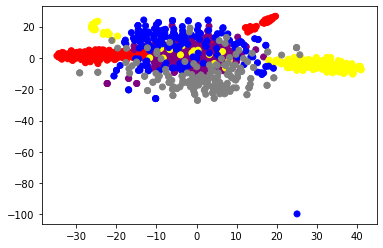

In [96]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(u[:,0], u[:,1],u[:,2], c = colors, alpha = .5)

plt.scatter(u[:,0], u[:,1], c = colors)

In [97]:
names

['sutras', 'vedas', 'bible', 'tanakh', 'quran']

,Text,Word,Rank,0,1,2,3,4,5,6,...,140,141,142,143,144,145,146,147,148,149
0,sutras,god,0,-0.062869,0.065445,-0.016017,-0.007218,-0.032833,-0.041352,0.080393,...,0.077104,-0.001632,0.017712,0.037506,-0.058375,-0.048837,-0.002403,0.030310,0.046083,0.019408
1,sutras,god,1,-0.011802,-0.080150,0.001521,-0.025512,0.035001,0.006595,0.017949,...,-0.022066,0.004359,0.020488,-0.022245,0.041649,0.043173,-0.011381,0.026406,-0.084352,0.055453
2,sutras,god,2,0.015371,-0.048616,0.048311,-0.040575,-0.041342,0.047973,-0.026539,...,-0.026139,-0.016199,-0.025407,-0.036268,-0.045445,0.022405,0.004828,0.040158,-0.030266,0.013993
3,sutras,god,3,0.015654,-0.050607,0.080055,0.001359,0.012369,0.045616,0.001100,...,-0.086322,0.013610,0.066001,-0.041166,0.039904,0.064762,0.071395,-0.014329,-0.050493,0.025086
4,sutras,god,4,-0.037020,0.025446,0.017828,-0.051863,-0.029393,0.055522,0.033823,...,-0.005426,0.034795,0.039512,0.007485,-0.031717,0.040550,-0.024070,0.047973,0.029486,-0.042274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,quran,evil,19,0.092568,-0.066405,0.099323,-0.167675,-0.081793,0.001258,0.150861,...,-0.012169,0.059452,-0.075299,0.127794,-0.058481,0.038411,0.022353,0.127616,-0.002673,-0.020014
836,quran,evil,20,-0.084996,-0.055955,0.037016,0.002143,0.050478,0.037160,-0.013976,...,-0.021911,0.039409,-0.001703,-0.025018,0.037483,-0.009649,0.002258,0.056967,-0.010354,-0.070519
837,quran,evil,21,-0.054840,0.003088,-0.060600,0.033656,0.040694,0.066464,-0.047649,...,-0.012024,-0.022278,0.007333,0.016216,-0.095678,-0.029105,0.024245,0.082088,0.087180,-0.001716
838,quran,evil,22,-0.052532,-0.037131,0.059668,-0.006654,0.014792,0.001134,0.006176,...,-0.052926,0.055587,-0.045016,0.022141,0.023726,0.010910,0.082517,0.066416,0.032524,-0.112444


840
840


240
240


In [127]:
def to_tensorflow_projector_mw(df):
    df = df[(df['Word'] == 'good') | (df['Word'] == 'evil')]
    print(len(df.iloc[:,3:]))
    print(len(df.iloc[:,:3]))
    df.iloc[:,3:].to_csv('projector_data_good_evil.tsv',sep='\t', index = False, header=False)
    df.iloc[:,:3].to_csv('projector_metadata_good_evil.tsv',sep='\t', index = False, header=True)
    

to_tensorflow_projector_mw(records)  

240
240


In [99]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
z = tsne.fit_transform(records.values[:,3:])



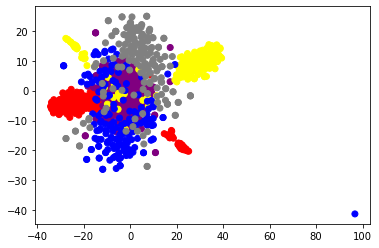

In [100]:
plt.scatter(z[:,0], z[:,1], c = colors)

# Compare Archetype "God"

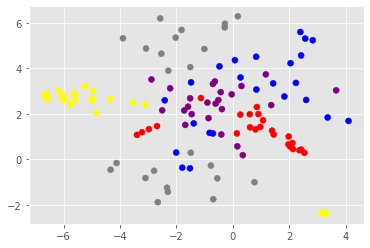

In [117]:
plt.style.use('ggplot')
god_vectors = records[records['Word'] == 'darkness'].values
tsne = TSNE(n_components = 2)
z = tsne.fit_transform(god_vectors[:,3:])

color_dict = {'sutras': 'red',
             'vedas': 'purple',
             'bible': 'yellow',
             'tanakh': 'blue',
             'quran': 'gray'}
color_num = 120//5
color_num
colors = [color_dict['sutras']]*color_num + \
         [color_dict['vedas']]*color_num + \
         [color_dict['bible']]*color_num + \
         [color_dict['tanakh']]*color_num + \
         [color_dict['quran']]*color_num 

plt.scatter(z[:,0], z[:,1], c = colors)

In [40]:
losses = load_obj('losses')

In [61]:
loss_df_orig = pd.DataFrame(losses)
loss_df = pd.DataFrame()

epochs, _ = zip(*loss_df_orig[col].values)

loss_df['epochs'] = epochs
for col in loss_df_orig.columns:
    _, loss = zip(*loss_df_orig[col].values)
    loss_df[col] = loss
    loss_df[col+'_mean'] = pd.Series(loss).expanding().mean()
    

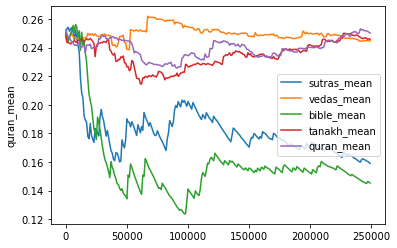

In [66]:
sns.lineplot(epochs, 'sutras_mean', data = loss_df, label = 'sutras_mean')
sns.lineplot(epochs, 'vedas_mean', data = loss_df, label = 'vedas_mean')
sns.lineplot(epochs, 'bible_mean', data = loss_df, label = 'bible_mean')
sns.lineplot(epochs, 'tanakh_mean', data = loss_df, label = 'tanakh_mean')
sns.lineplot(epochs, 'quran_mean', data = loss_df, label = 'quran_mean')

## Exp

What is the distance between light or good and dark or evil

In [77]:
m = load_model(r'C:\Users\jamesPC\source\repos\lstm_bible\model.h5')
m.layers